In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [2]:
################################################################################
#                            ForecasterAutoreg                                 #
#                                                                              #
# This work by Joaquin Amat Rodrigo and Javier Escobar Ortiz is licensed       #
# under a Creative Commons Attribution 4.0 International License.              #
################################################################################
# coding=utf-8

from typing import Union, Dict, List, Tuple, Any, Optional
import warnings
import logging
import sys
import numpy as np
import pandas as pd
from sklearn.base import clone
import pmdarima
from pmdarima.arima import ARIMA

import skforecast
from skforecast.utils import initialize_lags
from skforecast.utils import check_y
from skforecast.utils import check_exog
from skforecast.utils import preprocess_y
from skforecast.utils import preprocess_last_window
from skforecast.utils import preprocess_exog
from skforecast.utils import expand_index
from skforecast.utils import check_predict_input
from skforecast.utils import transform_series
from skforecast.utils import transform_dataframe

logging.basicConfig(
    format = '%(name)-10s %(levelname)-5s %(message)s', 
    level  = logging.INFO,
)

In [3]:
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import Ridge
import re
import pytest
from pmdarima.arima import ARIMA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [105]:
forecaster = ForecasterSarimax(
                regressor = ARIMA(order=(2,2,2), seasonal_order=(1,1,1,2))
            )

forecaster.regressor.get_params(deep=True)

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 2, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': None,
 'seasonal_order': (1, 1, 1, 2),
 'start_params': None,
 'suppress_warnings': False,
 'trend': None,
 'with_intercept': True}

In [4]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
display(data.head())

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [6]:
# Fixtures
y = pd.Series(
        data = np.array([0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                         0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                         0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                         0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                         0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                         0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                         0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                         0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                         0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                         0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]
            ),
        name = 'y'
    )

exog = pd.Series(
           data = np.array([0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                            0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                            0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                            0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                            0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                            0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                            0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                            0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                            0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                            0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
               ),
           name = 'exog'
       )


In [6]:
y_datetime = pd.Series(data=list(y))
y_datetime.index = pd.date_range(start='2000', periods=50, freq='A')
lw_datetime = pd.Series(data=list(y))
lw_datetime.index = pd.date_range(start='2050', periods=50, freq='A')
exog_datetime = pd.Series(data=list(exog))
exog_datetime.index = pd.date_range(start='2000', periods=50, freq='A')
lw_exog_datetime = pd.Series(data=list(exog))
lw_exog_datetime.index = pd.date_range(start='2050', periods=50, freq='A')

In [38]:
df_exog = pd.DataFrame({'exog_1': list(exog), 'exog_2': ['a']*25+['b']*25})
df_exog.index = pd.date_range(start='2000', periods=50, freq='A')
df_lw_exog = df_exog.copy()
df_lw_exog.index = pd.date_range(start='2050', periods=50, freq='A')

transformer_exog = ColumnTransformer(
                        [('scale', StandardScaler(), ['exog_1']),
                        ('onehot', OneHotEncoder(), ['exog_2'])],
                        remainder = 'passthrough',
                        verbose_feature_names_out = False
                    )

In [120]:
list(np.arange(20)+ 1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [60]:
y_datetime = pd.Series(data=list(y))
y_datetime.name = 'y'
y_datetime.index = pd.date_range(start='2000', periods=50, freq='A')

lw_datetime = pd.Series(data=list(y))
lw_datetime.name = 'y'
lw_datetime.index = pd.date_range(start='2050', periods=50, freq='A')

In [61]:
y_datetime.head(5)

2000-12-31    0.696469
2001-12-31    0.286139
2002-12-31    0.226851
2003-12-31    0.551315
2004-12-31    0.719469
Freq: A-DEC, Name: y, dtype: float64

In [44]:
lw_datetime.head(5)

2050-12-31    0.696469
2051-12-31    0.286139
2052-12-31    0.226851
2053-12-31    0.551315
2054-12-31    0.719469
Freq: A-DEC, Name: y, dtype: float64

In [70]:
np.random.seed(123)
y_datetime = pd.Series(data=np.random.rand(50))
y_datetime.name = 'y'
y_datetime.index = pd.date_range(start='2000', periods=50, freq='A')
print(y_datetime.head(5))

2000-12-31    0.696469
2001-12-31    0.286139
2002-12-31    0.226851
2003-12-31    0.551315
2004-12-31    0.719469
Freq: A-DEC, Name: y, dtype: float64


In [74]:
import session_info

session_info.show(html=False)

-----
numpy               1.23.5
pandas              1.4.0
pmdarima            2.0.2
pytest              7.1.2
session_info        1.0.0
skforecast          0.7.dev
sklearn             1.1.0
statsmodels         0.13.5
-----
IPython             8.5.0
jupyter_client      7.3.5
jupyter_core        4.11.1
notebook            6.4.12
-----
Python 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.19042-SP0
-----
Session information updated at 2023-01-09 12:08


In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

mod = SARIMAX(endog=y_datetime, order=(1,1,1))
print(y_datetime.head(5))
res = mod.fit()
print(y_datetime.head(5))
print(res.model.data.orig_endog.head(5))

# print(res.model.data.orig_endog)
# print(res.forecast(5))
# print(res.resid)

new_res = res.append(lw_datetime, refit=False)
# print(new_res.forecast(5))
# print(new_res.resid)

2000-12-31    0.696469
2001-12-31    0.286139
2002-12-31    0.226851
2003-12-31    0.551315
2004-12-31    0.719469
Freq: A-DEC, Name: y, dtype: float64
2000-12-31    0.696469
2001-12-31    0.286139
2002-12-31    0.226851
2003-12-31    0.551315
2004-12-31    0.719469
Freq: A-DEC, Name: y, dtype: float64
2000-12-31    0.696469
2001-12-31    0.286139
2002-12-31    0.226851
2003-12-31    0.551315
2004-12-31    0.719469
Freq: A-DEC, Name: y, dtype: float64


In [72]:
from pmdarima.arima import ARIMA

modl = ARIMA(order=(1,1,1))
res = modl.fit(y_datetime)
print(modl.arima_res_.model.data.orig_endog.head(5))
print(res.arima_res_.model.data.orig_endog.head(5))

modl.arima_res_ = modl.arima_res_.append(lw_datetime, refit=False)


2000-12-31    0.696469
2001-12-31    0.286139
2002-12-31    0.226851
2003-12-31    0.551315
2004-12-31    0.719469
Freq: A-DEC, dtype: float64
2000-12-31    0.696469
2001-12-31    0.286139
2002-12-31    0.226851
2003-12-31    0.551315
2004-12-31    0.719469
Freq: A-DEC, dtype: float64


ValueError: Columns must match to concatenate along rows.

In [40]:
# pmdarima SARIMAX
# =====================================================================================
kwargs = {'order': (1,1,1), 'seasonal_order': (0,0,0,0)}
forecaster = ForecasterSarimax(
                regressor = ARIMA(**kwargs),
                transformer_y    = StandardScaler(),
                transformer_exog = transformer_exog
            )
forecaster.fit(y=y_datetime, exog=df_exog)
# print(forecaster.regressor.arima_res_.model.exog_names)
print([round(value, 16) for value in forecaster.predict(steps=5, exog=df_exog, last_window=lw_datetime, last_window_exog=df_lw_exog).values])

kwargs = {'order': (1,1,1), 'seasonal_order': (1,1,1,2)}
forecaster = ForecasterSarimax(
                regressor = ARIMA(**kwargs),
                transformer_y    = StandardScaler(),
                transformer_exog = transformer_exog
            )
forecaster.fit(y=y_datetime, exog=df_exog)
print([round(value, 16) for value in forecaster.predict(steps=5, exog=df_exog, last_window=lw_datetime, last_window_exog=df_lw_exog).values])

y
2050-12-31    0.696469
2051-12-31    0.286139
2052-12-31    0.226851
2053-12-31    0.551315
2054-12-31    0.719469
Freq: A-DEC, Name: y, dtype: float64
y
2050-12-31    0.837129
2051-12-31   -0.927922
2052-12-31   -1.182952
2053-12-31    0.212741
2054-12-31    0.936063
Freq: A-DEC, dtype: float64
0
[1.0883760008461447, 0.9596655915602446, 1.0164563275894087, 1.0368122358153902, 1.0879339700749853]
y
2050-12-31    0.696469
2051-12-31    0.286139
2052-12-31    0.226851
2053-12-31    0.551315
2054-12-31    0.719469
Freq: A-DEC, Name: y, dtype: float64
y
2050-12-31    0.837129
2051-12-31   -0.927922
2052-12-31   -1.182952
2053-12-31    0.212741
2054-12-31    0.936063
Freq: A-DEC, dtype: float64
0
[1.1359948592023694, 1.0197787345609874, 1.0563186630823083, 1.0890821402058224, 1.1539621608480948]


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults
np.random.seed(123)

y_datetime = pd.Series(data=list(y))
y_datetime.name = 'y'
y_datetime.index = pd.date_range(start='2000', periods=50, freq='A')

lw_datetime = pd.Series(data=list(y))
lw_datetime.name = 'y'
lw_datetime.index = pd.date_range(start='2050', periods=50, freq='A')

mod = SARIMAX(endog=y_datetime, order=(1,1,1))
res = mod.fit()
print(type(res))

print(res.model.data.orig_endog)
# print(res.forecast(5))
# print(res.resid)

# new_res = res.append(lw_datetime, refit=False)
# print(new_res.forecast(5))
# print(new_res.resid)

<class 'statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper'>
2000-12-31    0.696469
2001-12-31    0.286139
2002-12-31    0.226851
2003-12-31    0.551315
2004-12-31    0.719469
2005-12-31    0.423106
2006-12-31    0.980764
2007-12-31    0.684830
2008-12-31    0.480932
2009-12-31    0.392118
2010-12-31    0.343178
2011-12-31    0.729050
2012-12-31    0.438572
2013-12-31    0.059678
2014-12-31    0.398044
2015-12-31    0.737995
2016-12-31    0.182492
2017-12-31    0.175452
2018-12-31    0.531551
2019-12-31    0.531828
2020-12-31    0.634401
2021-12-31    0.849432
2022-12-31    0.724455
2023-12-31    0.611024
2024-12-31    0.722443
2025-12-31    0.322959
2026-12-31    0.361789
2027-12-31    0.228263
2028-12-31    0.293714
2029-12-31    0.630976
2030-12-31    0.092105
2031-12-31    0.433701
2032-12-31    0.430863
2033-12-31    0.493685
2034-12-31    0.425830
2035-12-31    0.312261
2036-12-31    0.426351
2037-12-31    0.893389
2038-12-31    0.944160
2039-12-31    0.501837
2040-12-31   

In [13]:
forecaster.predict(steps=5, last_window=lw_datetime)

ValueError: Forecaster trained with exogenous variable/s. Same variable/s must be provided in `predict()`.

In [7]:
df_exog = pd.DataFrame({
                'exog_1': exog,
                'exog_2': ['a']*25+['b']*25}
            )
transformer_exog = ColumnTransformer(
                        [('scale', StandardScaler(), ['exog_1']),
                        ('onehot', OneHotEncoder(), ['exog_2'])],
                        remainder = 'passthrough',
                        verbose_feature_names_out = False
                    )

kwargs = {'order': (1,1,1), 'seasonal_order': (0,0,0,0)}
forecaster = ForecasterSarimax(
                regressor = ARIMA(**kwargs),
                transformer_y    = StandardScaler(),
                transformer_exog = transformer_exog
            )
forecaster.fit(y=y, exog=df_exog)
print([round(value, 16) for value in forecaster.predict(steps=5, exog=df_exog).values])

kwargs = {'order': (1,1,1), 'seasonal_order': (1,1,1,2)}
forecaster = ForecasterSarimax(
                regressor = ARIMA(**kwargs),
                transformer_y    = StandardScaler(),
                transformer_exog = transformer_exog
            )
forecaster.fit(y=y, exog=df_exog)
print([round(value, 16) for value in forecaster.predict(steps=5, exog=df_exog).values])

[0.9084670377251036, 0.7647883047064794, 0.8203336846873355, 0.8405859799961493, 0.8916990937197793]
[1.0095544323406163, 0.8707230817689734, 0.925811215455429, 0.9522848237323704, 1.0168960034047383]


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
# pmdarima SARIMAX
# =====================================================================================
forecaster = ForecasterSarimax(
                regressor = ARIMA(order=(1,1,1))
            )
forecaster.fit(y=y)
forecaster.predict(steps=5).values

array([0.53566226, 0.5235128 , 0.5220779 , 0.52240695, 0.52302639])

In [9]:
# pmdarima SARIMAX
# =====================================================================================
forecaster = ForecasterSarimax(
                regressor = ARIMA(order=(1,1,1), seasonal_order=(1,1,1,2))
            )
forecaster.fit(y=y)
forecaster.predict(steps=5).values

array([0.64306902, 0.60507108, 0.63972942, 0.62851983, 0.66561887])

In [15]:
y_datetime = pd.Series(data=y)
y_datetime.index = pd.date_range(start='2022-01-01', periods=50)
exog_datetime = pd.Series(data=exog)
exog_datetime.index = pd.date_range(start='2022-01-01', periods=50)
lw_datetime = pd.Series(data=np.random.rand(50))
lw_datetime.index = pd.date_range(start='2022-02-20', periods=50)
lw_exog_datetime = pd.Series(data=np.random.rand(50))
lw_exog_datetime.index = pd.date_range(start='2022-03-01', periods=50)

forecaster = ForecasterSarimax(regressor= ARIMA(order=(1,1,1)))
forecaster.fit(y=y_datetime, exog=exog_datetime)
forecaster.predict(5, exog=exog_datetime, last_window=lw_datetime, last_window_exog=lw_exog_datetime)

2022-01-01    0.696469
2022-01-02    0.286139
2022-01-03    0.226851
2022-01-04    0.551315
2022-01-05    0.719469
Freq: D, Name: y, dtype: float64
2022-01-01    0.696469
2022-01-02    0.286139
2022-01-03    0.226851
2022-01-04    0.551315
2022-01-05    0.719469
Freq: D, Name: y, dtype: float64


ValueError: To make predictions unrelated to the original data, `last_window_exog` has to start at the end of the training set.
    Series last index              : 2022-02-19 00:00:00.
    Expected index                 : 2022-02-20 00:00:00.
    `last_window_exog` index start : 2022-03-01 00:00:00.

In [94]:
y_datetime = pd.Series(data=y)
y_datetime.index = pd.date_range(start='2022-01-01', periods=50)
exog_datetime = pd.Series(data=list(exog) + list(exog))
exog_datetime.index = pd.date_range(start='2022-01-02', periods=100)
lw_datetime = pd.Series(data=y)
lw_datetime.index = pd.date_range(start='2022-02-20', periods=50)
# lw_exog_datetime = pd.Series(data=exog)
# lw_exog_datetime.index = pd.date_range(start='2022-03-01', periods=50)

forecaster = ForecasterSarimax(regressor= ARIMA(order=(1,1,1)))
forecaster.fit(y=y_datetime, exog=exog_datetime)
expected_index = expand_index(forecaster.last_window.index, 1)[0]

err_msg = re.escape(
    (f'To make predictions unrelated to the original data, `last_window_exog` '
        f'has to start at the end of the training set.\n'
        f'    Series last index              : {forecaster.last_window.index[-1]}.\n'
        f'    Expected index                 : {expected_index}.\n'
        f'    `last_window_exog` index start : {lw_exog_datetime.index[0]}.')
)
with pytest.raises(ValueError, match = err_msg):
    forecaster.predict(steps=5, last_window=lw_datetime, last_window_exog=lw_exog_datetime)

2022-01-01    0.696469
2022-01-02    0.286139
2022-01-03    0.226851
2022-01-04    0.551315
2022-01-05    0.719469
2022-01-06    0.423106
2022-01-07    0.980764
2022-01-08    0.684830
2022-01-09    0.480932
2022-01-10    0.392118
2022-01-11    0.343178
2022-01-12    0.729050
2022-01-13    0.438572
2022-01-14    0.059678
2022-01-15    0.398044
2022-01-16    0.737995
2022-01-17    0.182492
2022-01-18    0.175452
2022-01-19    0.531551
2022-01-20    0.531828
2022-01-21    0.634401
2022-01-22    0.849432
2022-01-23    0.724455
2022-01-24    0.611024
2022-01-25    0.722443
2022-01-26    0.322959
2022-01-27    0.361789
2022-01-28    0.228263
2022-01-29    0.293714
2022-01-30    0.630976
2022-01-31    0.092105
2022-02-01    0.433701
2022-02-02    0.430863
2022-02-03    0.493685
2022-02-04    0.425830
2022-02-05    0.312261
2022-02-06    0.426351
2022-02-07    0.893389
2022-02-08    0.944160
2022-02-09    0.501837
2022-02-10    0.623953
2022-02-11    0.115618
2022-02-12    0.317285
2022-02-13 

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterSarimax\ForecasterSarimax.py:251: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None` will be used as the name of the resulting DataFrame column.
  exog = exog.to_frame(name=exog.name)


ValueError: The indices for endog and exog are not aligned

In [76]:
y_datetime = pd.Series(data=y)
y_datetime.index = pd.date_range(start='2022-01-01', periods=50, freq='D')
lw_datetime = pd.Series(data=y)
lw_datetime.index = pd.date_range(start='2022-03-01', periods=50, freq='D')

forecaster = ForecasterSarimax(regressor= ARIMA(order=(1,1,1)))
forecaster.fit(y=y_datetime)
expected_index = expand_index(forecaster.last_window.index, 1)[0]

err_msg = re.escape(
    (f'To make predictions unrelated to the original data, `last_window` '
        f'has to start at the end of the training set.\n'
        f'    Series last index         : {forecaster.last_window.index[-1]}.\n'
        f'    Expected index            : {expected_index}.\n'
        f'    `last_window` index start : {lw_datetime.index[0]}.')
)
with pytest.raises(ValueError, match = err_msg):
    forecaster.predict(steps=5, last_window=lw_datetime)

In [10]:
import re
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterSarimax import ForecasterSarimax
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

err_msg = re.escape(
            (f"regressor must be an instance of type pmdarima.arima.ARIMA. "
                f"Got {type(regressor)}.")
        ) 
with pytest.raises(ValueError, match = err_msg):
    ForecasterSarimax(regressor = regressor)

In [15]:
ARIMA(order=(1,1,1)).get_params(deep=True)

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': None,
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': False,
 'trend': None,
 'with_intercept': True}

In [16]:
f = ForecasterSarimax(regressor = ARIMA(order=(1,1,1)))

In [18]:
f.params == ARIMA(order=(1,1,1)).get_params(deep=True)

True

In [7]:
# pmdarima SARIMAX
# =====================================================================================
forecaster = ForecasterSarimax(
                regressor = ARIMA(order=(5,2,4), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000)
            )
forecaster


ForecasterSarimax 
Regressor:  ARIMA(1,1,5)(0,0,0)[0]           
Regressor parameters: {'maxiter': 1000, 'method': 'lbfgs', 'order': (1, 1, 5), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': None, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': False, 'trend': None, 'with_intercept': False} 
Window size: 5 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Creation date: 2022-12-27 17:13:35 
Last fit date: None 
Skforecast version: 0.7.dev 
Python version: 3.9.13 

In [28]:
data_train['y'].tail()

date
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [34]:
import math

def internally_studentized_residual(X,Y):
    X = np.array(X, dtype=float)
    Y = np.array(Y, dtype=float)
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    n = len(X)
    diff_mean_sqr = np.dot((X - mean_X), (X - mean_X))
    beta1 = np.dot((X - mean_X), (Y - mean_Y)) / diff_mean_sqr
    beta0 = mean_Y - beta1 * mean_X
    y_hat = beta0 + beta1 * X
    residuals = Y - y_hat
    h_ii = (X - mean_X) ** 2 / diff_mean_sqr + (1 / n)
    Var_e = math.sqrt(sum((Y - y_hat) ** 2)/(n-2))
    SE_regression = Var_e*((1-h_ii) ** 0.5)
    studentized_residuals = residuals/SE_regression
    
    return studentized_residuals

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

index = pd.period_range(start='2000', periods=3, freq='A')
original_observations = pd.Series([1.2, 1.5, 1.8], index=index)
original_exog = pd.Series([2, 2.7, 1.3], index=index)
mod = SARIMAX(endog=original_observations, exog=original_exog)
res = mod.fit()
# print(res.params)
# print(res.fittedvalues)
# print(res.predict(1))
print(res.forecast(1, exog=original_exog.iloc[-1,]))

2003    0.398534
Freq: A-DEC, dtype: float64


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
np.random.seed(123)
y_datetime = pd.Series(data=y, name='y')
y_datetime.index = pd.date_range(start='2022-01-01', periods=50, freq='D')
lw_datetime = pd.Series(data=exog, name='y')
lw_datetime.index = pd.date_range(start='2022-02-20', periods=50, freq='D')

index = pd.date_range(start='2000', periods=50, freq='A')
original_observations = pd.Series(np.random.random(50), index=index)
mod = SARIMAX(endog=y_datetime, order=(1,1,1))
res = mod.fit()
print(res.forecast(5))
# print(res.resid)

new_index = pd.date_range(start='2050', periods=15, freq='A')
new_observations = pd.Series(np.random.random(15), index=new_index)
new_exog = pd.Series(np.random.random(15), index=new_index)
new_res = res.append(lw_datetime, refit=False)
print(new_res.forecast(5))
# print(new_res.resid)

2022-02-20    0.521401
2022-02-21    0.506132
2022-02-22    0.503583
2022-02-23    0.503158
2022-02-24    0.503087
Freq: D, Name: predicted_mean, dtype: float64
2022-04-11    0.475126
2022-04-12    0.497101
2022-04-13    0.500768
2022-04-14    0.501380
2022-04-15    0.501482
Freq: D, Name: predicted_mean, dtype: float64


In [151]:
new_index = pd.period_range(start='1980', periods=3, freq='A')
new_observations = pd.Series([1.4, 0.3, 1.2], index=new_index)
new_exog = pd.Series([6, 4.3, 3.1], index=new_index)
new_res = res.apply(new_observations, exog=new_exog, refit=False)
# print(new_res.params)
# print(new_res.fittedvalues)
# print(new_res.predict(1))
print(new_res.forecast(1, exog=original_exog.iloc[-1,]))

new_index = pd.period_range(start='1980', periods=3, freq='A')
new_observations = pd.Series([1.4, 0.3, 1.2], index=new_index)
new_exog = pd.Series([6, 4.3, 3.1], index=new_index)
new_res = res.apply(new_observations, exog=new_exog, refit=True)
# print(new_res.params)
# print(new_res.fittedvalues)
# print(new_res.predict(1))
print(new_res.forecast(1, exog=original_exog.iloc[-1,]))

1983    1.405683
Freq: A-DEC, dtype: float64
1983   -0.379792
Freq: A-DEC, dtype: float64


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [44]:
# Try append
index = pd.period_range(start='2000', periods=3, freq='A')
original_observations = pd.Series([1.2, 1.5, 1.8], index=index)
original_exog = pd.Series([2, 2.7, 1.3], index=index)
mod = SARIMAX(endog=original_observations, exog=original_exog)
res = mod.fit()
print(res.forecast(1, exog=original_exog.iloc[-1,]))

new_index = pd.period_range(start='2003', periods=3, freq='A')
new_observations = pd.Series([1.4, 0.3, 1.2], index=new_index)
new_exog = pd.Series([6, 4.3, 3.1], index=new_index)
new_res = res.append(new_observations, exog=new_exog, refit=False)
print(new_res.forecast(1, exog=original_exog.iloc[-1,]))

new_index = pd.period_range(start='2003', periods=3, freq='A')
new_observations = pd.Series([1.4, 0.3, 1.2], index=new_index)
new_exog = pd.Series([6, 4.3, 3.1], index=new_index)
new_res = res.append(new_observations, exog=new_exog, refit=True)
print(new_res.forecast(1, exog=original_exog.iloc[-1,]))

2003    0.398534
Freq: A-DEC, dtype: float64
2006    1.405683
Freq: A-DEC, dtype: float64
2006    1.008943
Freq: A-DEC, dtype: float64


c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [119]:
new_index = pd.period_range(start='1980', periods=3, freq='A')
new_observations = pd.Series([1.4, 0.3, 1.2], index=new_index)
new_res = res.apply(new_observations, refit=True)
print(res.params)
print(res.fittedvalues)
print(res.predict(1))
print(res.forecast(1))

ar.L1     0.975611
sigma2    0.088896
dtype: float64
2000    0.000000
2001    1.170734
Freq: A-DEC, dtype: float64
2001    1.170734
Freq: A-DEC, dtype: float64
2002    1.463417
Freq: A-DEC, dtype: float64


In [112]:
new_index = pd.period_range(start='2000', periods=2, freq='A')
new_observations = pd.Series([1.2, 1.5], index=new_index)
new_res = res.apply(original_observations, refit=False)
print(new_res.params)
print(new_res.fittedvalues)
print(new_res.predict(1))
print(new_res.forecast(1))

ar.L1     0.975611
sigma2    0.088896
dtype: float64
2000    0.000000
2001    1.170734
Freq: A-DEC, dtype: float64
2001    1.170734
Freq: A-DEC, dtype: float64
2002    1.463417
Freq: A-DEC, dtype: float64


In [103]:
data_train['y'].tail()

date
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [9]:
len(data_train['y'])

159

In [10]:
forecaster_1 = ForecasterSarimax(
                regressor = ARIMA(order=(5,1,2), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
            )
forecaster_1.fit(y=data_train['y'])
pred_1 = forecaster_1.predict(steps=5)

lengths = list(range(11))
preds_2 = [pred_1]

for n in lengths:
    forecaster_2 = ForecasterSarimax(
                    regressor = ARIMA(order=(5,1,2), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
                )
    forecaster_2.fit(y=data_train['y'])
    pred_2 = forecaster_2.predict(steps=5, last_window=data_train['y'].iloc[-n:])
    # pred_2 = forecaster_2.predict(steps=5)
    pred_2.name = f'{n}'
    preds_2.append(pred_2)

pd.concat(preds_2, axis=1)

,pred,0,1,2,3,4,5,6,7,8,9,10
2005-07-01,1.038069,1.038069,0.842263,0.833381,0.829829,0.829618,0.817113,1.005752,1.015432,1.023569,1.023187,1.036177
2005-08-01,1.020495,1.020495,0.842263,0.818446,0.814931,0.807379,0.775644,0.981915,1.014866,1.022976,1.021279,1.033344
2005-09-01,1.098529,1.098529,0.842263,0.819509,0.809401,0.790564,0.758521,1.046817,1.077625,1.089497,1.087997,1.106317
2005-10-01,1.025232,1.025232,0.842263,0.790720,0.769937,0.750927,0.710632,0.975736,1.017477,1.027921,1.025775,1.041339
2005-11-01,0.993463,0.993463,0.842263,0.745958,0.725775,0.701957,0.666837,0.943114,0.978103,0.989287,0.987537,1.004571


In [161]:
# Try changing exog and with all series as last window
forecaster_1 = ForecasterSarimax(
                regressor = ARIMA(order=(5,2,3), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
            )
forecaster_1.fit(y=data_train['y'], exog=data_train['exog_1'])
pred_1 = forecaster_1.predict(steps=5, exog=data_test['exog_1'])

lengths = list(range(5))
lengths = 0
# lengths = list(range(25, 30))
preds_2 = [pred_1]

for i, lw_exog in enumerate([data_train['y'], data_train['exog_1']]):
    forecaster_2 = ForecasterSarimax(
                    regressor = ARIMA(order=(5,2,3), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
                )
    forecaster_2.fit(y=data_train['y'], exog=data_train['exog_1'])
    pred_2 = forecaster_2.predict(steps=5, exog=data_test['exog_1'], last_window=data_train['y'], last_window_exog=lw_exog)
    # pred_2 = forecaster_2.predict(steps=5)
    pred_2.name = f'{i}'
    preds_2.append(pred_2)

pd.concat(preds_2, axis=1)

,pred,0,1
2005-07-01,0.834083,1.583247,0.834083
2005-08-01,0.775471,1.570892,0.775471
2005-09-01,0.763014,1.549400,0.763014
2005-10-01,0.738576,1.517228,0.738576
2005-11-01,0.700156,1.524830,0.700156


In [49]:
forecaster_1 = ForecasterSarimax(
                regressor = ARIMA(order=(5,2,3), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
            )
forecaster_1.fit(y=data_train['y'], exog=data_train['exog_1'])

In [76]:
from skforecast.utils import expand_index

new_index = pd.date_range(start='2005-07-01', periods=3, freq=forecaster.index_freq)
lw_2 = pd.Series([1.4, 0.3, 1.2], index=new_index)

print(lw_2[0])
expand_index(forecaster_1.last_window.index, 1)[0] == lw_2.index[0]


1.4


True

In [86]:
expected_index = expand_index(forecaster_1.last_window.index, 1)[0]

print(
    (f'To make predictions unrelated to the original data, `last_window` '
        f'has to start at the end of the training set.\n'
        f'    Series last index         : {forecaster_1.last_window.index[-1]}.\n'
        f'    Expected index            : {expected_index}.\n'
        f'    `last_window` index start : {lw_2.index[0]}.')
)

To make predictions unrelated to the original data, `last_window` has to start at the end of the training set.
    Series last index         : 2005-06-01 00:00:00.
    Expected index            : 2005-07-01 00:00:00.
    `last_window` index start : 2005-07-01 00:00:00.


In [169]:
forecaster_1.regressor.predict(n_periods=36, X=data_test['exog_1'].to_frame())

2005-07-01    0.834083
2005-08-01    0.775471
2005-09-01    0.763014
2005-10-01    0.738576
2005-11-01    0.700156
2005-12-01    0.803202
2006-01-01    0.877273
2006-02-01    0.840496
2006-03-01    0.868976
2006-04-01    0.834666
2006-05-01    0.805690
2006-06-01    0.804989
2006-07-01    0.764330
2006-08-01    0.753788
2006-09-01    0.757883
2006-10-01    0.742118
2006-11-01    0.718698
2006-12-01    0.809200
2007-01-01    0.857758
2007-02-01    0.850377
2007-03-01    0.853802
2007-04-01    0.803226
2007-05-01    0.787759
2007-06-01    0.772675
2007-07-01    0.747909
2007-08-01    0.742488
2007-09-01    0.751111
2007-10-01    0.731793
2007-11-01    0.732950
2007-12-01    0.812696
2008-01-01    0.864117
2008-02-01    0.900863
2008-03-01    0.888723
2008-04-01    0.874010
2008-05-01    0.867312
2008-06-01    0.823210
Freq: MS, dtype: float64

In [11]:
forecaster_1.regressor.df_model()

8

In [12]:
forecaster_1.regressor.df_resid()

inf

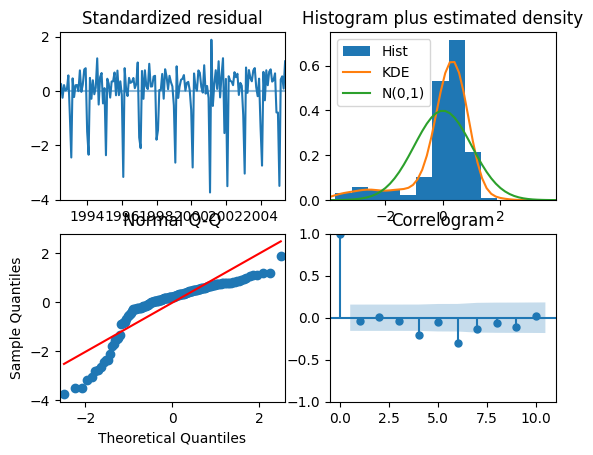

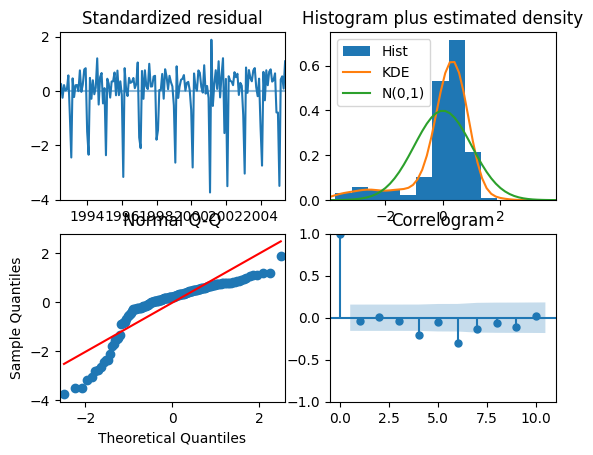

In [172]:
forecaster_1.regressor.plot_diagnostics()

In [127]:
forecaster_1.regressor.arima_res_.fittedvalues

date
1992-04-01    0.000000
1992-05-01    0.371971
1992-06-01    0.355788
1992-07-01    0.402180
1992-08-01    0.464897
                ...   
2005-02-01    1.146735
2005-03-01    0.632435
2005-04-01    0.706293
2005-05-01    0.669381
2005-06-01    0.764826
Freq: MS, Length: 159, dtype: float64

In [128]:
forecaster_2.regressor.arima_res_.fittedvalues

date
2004-10-01    0.000000
2004-11-01    1.156641
2004-12-01    1.190377
2005-01-01    1.228937
2005-02-01    1.151603
2005-03-01    0.632435
2005-04-01    0.706293
2005-05-01    0.669381
2005-06-01    0.764826
Freq: MS, dtype: float64

In [94]:
# Params
print(forecaster_1.regressor.arima_res_.params)
print(forecaster_2.regressor.arima_res_.params)
print('')

# Array containing autoregressive lag polynomial coefficients, ordered from lowest degree to highest. 
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).
print(forecaster_1.regressor.arima_res_.polynomial_ar)
print(forecaster_2.regressor.arima_res_.polynomial_ar)
print('')

# Array containing moving average lag polynomial coefficients, ordered from lowest degree to highest. 
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).print(forecaster_1.regressor.arima_res_.polynomial_ar)
print(forecaster_1.regressor.arima_res_.polynomial_ma)
print(forecaster_2.regressor.arima_res_.polynomial_ma)

ar.L1    -0.278167
ar.L2     0.208110
ar.L3     0.905169
ar.L4     0.149358
ar.L5    -0.038833
ma.L1     1.292218
ma.L2     0.998973
sigma2    0.018479
dtype: float64
ar.L1    -0.278167
ar.L2     0.208110
ar.L3     0.905169
ar.L4     0.149358
ar.L5    -0.038833
ma.L1     1.292218
ma.L2     0.998973
sigma2    0.018479
dtype: float64

[ 1.          0.2781674  -0.2081097  -0.9051687  -0.14935803  0.03883274]
[ 1.          0.2781674  -0.2081097  -0.9051687  -0.14935803  0.03883274]

[1.         1.29221759 0.99897309]
[1.         1.29221759 0.99897309]


In [44]:
data_train['y'].iloc[-1:]

date
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [47]:
forecaster_2.regressor.arima_res_.polynomial_ma

array([ 1.        , -1.29225707,  0.48184762,  0.48315573, -1.29717801,
        0.98581836])

In [42]:
# Array containing seasonal autoregressive lag polynomial coefficients, ordered from lowest degree to highest. 
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).
print(forecaster_1.regressor.arima_res_.polynomial_seasonal_ar)
print(forecaster_2.regressor.arima_res_.polynomial_seasonal_ar)
print('')

# Array containing seasonal moving average lag polynomial coefficients, ordered from lowest degree to highest.
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).
print(forecaster_1.regressor.arima_res_.polynomial_seasonal_ma)
print(forecaster_2.regressor.arima_res_.polynomial_seasonal_ma)

[1.]
[1.]

[1.]
[1.]


In [43]:
# Array containing trend polynomial coefficients, ordered from lowest degree to highest. 
# Initialized with ones, unless a coefficient is constrained to be zero (in which case it is zero).
print(forecaster_1.regressor.arima_res_.polynomial_trend)
print(forecaster_2.regressor.arima_res_.polynomial_trend)
print('')

# The orders of each of the polynomials in the model.
print(forecaster_1.regressor.arima_res_.model_orders)
print(forecaster_2.regressor.arima_res_.model_orders)
print('')

# List of parameters actually included in the model, in sorted order.
print(forecaster_1.regressor.arima_res_.param_terms)
print(forecaster_2.regressor.arima_res_.param_terms)

[]
[]

{'trend': 0, 'exog': 0, 'ar': 5, 'ma': 5, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 5, 'reduced_ma': 5, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}
{'trend': 0, 'exog': 0, 'ar': 5, 'ma': 5, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 5, 'reduced_ma': 5, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}

['ar', 'ma', 'variance']
['ar', 'ma', 'variance']


In [26]:
data_train['y'].iloc[-6:]

date
2005-01-01    1.170690
2005-02-01    0.597639
2005-03-01    0.652590
2005-04-01    0.670505
2005-05-01    0.695248
2005-06-01    0.842263
Freq: MS, Name: y, dtype: float64

In [30]:
data_train['exog_1'].iloc[-5:]

date
2005-02-01    1.520544
2005-03-01    1.506290
2005-04-01    1.487660
2005-05-01    1.457025
2005-06-01    1.441765
Freq: MS, Name: exog_1, dtype: float64

In [124]:
forecaster = ForecasterSarimax(
                regressor = ARIMA(order=(5,0,0), seasonal_order=(0, 0, 0, 0), trend=None, with_intercept=False, maxiter=1000, suppress_warnings=True)
            )
forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])
forecaster.predict(steps=5, exog=data_test['exog_1'])

2005-07-01    0.955160
2005-08-01    0.999309
2005-09-01    1.006797
2005-10-01    0.966844
2005-11-01    0.899705
Freq: MS, Name: pred, dtype: float64

In [ ]:
forecaster.regressor.arima_res_.apply(
    endog = last_window,
    exog  = last_window_exog,
    refit = False
)

In [125]:
forecaster.regressor.arima_res_.fittedvalues

date
1992-04-01    0.586089
1992-05-01    0.448589
1992-06-01    0.453344
1992-07-01    0.509825
1992-08-01    0.580687
                ...   
2005-02-01    0.959333
2005-03-01    0.585896
2005-04-01    0.648927
2005-05-01    0.655163
2005-06-01    0.782031
Freq: MS, Length: 159, dtype: float64

In [29]:
forecaster.predict(
    steps=5,
    exog=data_test['exog_1'],
    last_window=data_train['y'].iloc[-5:],
    last_window_exog=data_train['exog_1'].iloc[-5:]
)

2005-07-01    0.757604
2005-08-01    0.684084
2005-09-01    0.618403
2005-10-01    0.560564
2005-11-01    0.571627
Freq: MS, Name: pred, dtype: float64

In [32]:
forecaster.predict(
    steps=5,
    exog=data_test['exog_1'],
    last_window=data_train['y'].iloc[-5:],
    last_window_exog=data_train['y'].iloc[-5:]
)

2005-07-01    1.348155
2005-08-01    1.327842
2005-09-01    1.312205
2005-10-01    1.287929
2005-11-01    1.287166
Freq: MS, Name: pred, dtype: float64

In [11]:
forecaster.predict_interval(steps=5, exog=data_test['exog_1'])

,pred,lower_bound,upper_bound
2005-07-01,0.932642,0.696401,1.168883
2005-08-01,1.010520,0.740315,1.280726
2005-09-01,1.033868,0.761807,1.305928
2005-10-01,0.988795,0.712712,1.264877
2005-11-01,0.945110,0.652227,1.237994


In [12]:
forecaster.predict_interval(
    steps=5,
    exog=data_test['exog_1'],
    last_window=data_train['y'].iloc[-6:],
    last_window_exog=data_train['exog_1'].iloc[-6:]
)

,pred,lower_bound,upper_bound
2005-07-01,0.804699,0.533423,1.075975
2005-08-01,0.795028,0.446933,1.143122
2005-09-01,0.780490,0.408405,1.152576
2005-10-01,0.742509,0.374417,1.110601
2005-11-01,0.735371,0.378384,1.092358


## Test predict interval

In [94]:
y = pd.Series(
        data = np.array([0.69646919, 0.28613933, 0.22685145, 0.55131477, 0.71946897,
                         0.42310646, 0.9807642 , 0.68482974, 0.4809319 , 0.39211752,
                         0.34317802, 0.72904971, 0.43857224, 0.0596779 , 0.39804426,
                         0.73799541, 0.18249173, 0.17545176, 0.53155137, 0.53182759,
                         0.63440096, 0.84943179, 0.72445532, 0.61102351, 0.72244338,
                         0.32295891, 0.36178866, 0.22826323, 0.29371405, 0.63097612,
                         0.09210494, 0.43370117, 0.43086276, 0.4936851 , 0.42583029,
                         0.31226122, 0.42635131, 0.89338916, 0.94416002, 0.50183668,
                         0.62395295, 0.1156184 , 0.31728548, 0.41482621, 0.86630916,
                         0.25045537, 0.48303426, 0.98555979, 0.51948512, 0.61289453]
            ),
        name = 'y'
    )

exog = pd.Series(
           data = np.array([0.12062867, 0.8263408 , 0.60306013, 0.54506801, 0.34276383,
                            0.30412079, 0.41702221, 0.68130077, 0.87545684, 0.51042234,
                            0.66931378, 0.58593655, 0.6249035 , 0.67468905, 0.84234244,
                            0.08319499, 0.76368284, 0.24366637, 0.19422296, 0.57245696,
                            0.09571252, 0.88532683, 0.62724897, 0.72341636, 0.01612921,
                            0.59443188, 0.55678519, 0.15895964, 0.15307052, 0.69552953,
                            0.31876643, 0.6919703 , 0.55438325, 0.38895057, 0.92513249,
                            0.84167   , 0.35739757, 0.04359146, 0.30476807, 0.39818568,
                            0.70495883, 0.99535848, 0.35591487, 0.76254781, 0.59317692,
                            0.6917018 , 0.15112745, 0.39887629, 0.2408559 , 0.34345601]
               ),
           name = 'exog'
       )

transformer_exog = ColumnTransformer(
                        [('scale', StandardScaler(), ['exog_1']),
                        ('onehot', OneHotEncoder(), ['exog_2'])],
                        remainder = 'passthrough',
                        verbose_feature_names_out = False
                    )

df_exog = pd.DataFrame({
                  'exog_1': exog,
                  'exog_2': ['a']*25+['b']*25}
              )

In [96]:
kwargs = {'order': (1,1,1), 'seasonal_order': (0,0,0,0)}
forecaster = ForecasterSarimax(
                regressor = ARIMA(**kwargs),
                transformer_y    = StandardScaler(),
                transformer_exog = transformer_exog
            )
forecaster.fit(y=y, exog=df_exog)
predictions = forecaster.predict_interval(steps=5, exog=df_exog, alpha=0.05)
predictions.values

array([[0.90846704, 0.47796249, 1.33897159],
       [0.7647883 , 0.33209942, 1.19747719],
       [0.82033368, 0.38757178, 1.25309559],
       [0.84058598, 0.40781874, 1.27335322],
       [0.89169909, 0.4589314 , 1.32446679]])

In [92]:
alpha=0.05
interval=[1,99]
alpha=None
interval=[2.5,97.5]

forecaster = ForecasterSarimax(regressor=ARIMA(order=(1,1,1)), transformer_y = StandardScaler())
forecaster.fit(y=y)
predictions = forecaster.predict_interval(steps=5, alpha=alpha, interval=interval)
expected = pd.DataFrame(
                data    = np.array([[0.53572671, 0.07602913, 0.99542429],
                                    [0.52359439, 0.05626217, 0.99092661],
                                    [0.52216565, 0.05439018, 0.98994111],
                                    [0.52249851, 0.05467184, 0.99032517],
                                    [0.52312129, 0.05528678, 0.99095581]]),
                columns = ['pred', 'lower_bound', 'upper_bound'],
                index   = pd.RangeIndex(start=50, stop=55, step=1)
            )

pd.testing.assert_frame_equal(predictions, expected)

In [88]:
alpha=0.05
interval=[1,99]
# alpha=None
# interval=[2.5,97.5]

forecaster = ForecasterSarimax(regressor=ARIMA(order=(1,1,1)))
forecaster.fit(y=y, exog=exog)
predictions = forecaster.predict_interval(steps=5, exog=exog, alpha=alpha, interval=interval)
expected = pd.DataFrame(
                data    = np.array([[0.60497852,  0.15960892, 1.05034811],
                                    [0.44483443, -0.00619962, 0.89586848],
                                    [0.49239874,  0.04107972, 0.94371776],
                                    [0.50520397,  0.05385485, 0.95655309],
                                    [0.54934541,  0.09799221, 1.00069861]]),
                columns = ['pred', 'lower_bound', 'upper_bound'],
                index   = pd.RangeIndex(start=50, stop=55, step=1)
            )

pd.testing.assert_frame_equal(predictions, expected)

In [107]:
alpha=0.05

y_datetime = pd.Series(data=list(y))
y_datetime.index = pd.date_range(start='2000', periods=50, freq='A')
lw_datetime = pd.Series(data=list(y))
lw_datetime.index = pd.date_range(start='2050', periods=50, freq='A')

exog_datetime = pd.Series(data=list(exog))
exog_datetime.index = pd.date_range(start='2000', periods=50, freq='A')
lw_exog_datetime = pd.Series(data=list(exog))
lw_exog_datetime.index = pd.date_range(start='2050', periods=50, freq='A')

forecaster = ForecasterSarimax(regressor=ARIMA(order=(1,1,1)))
forecaster.fit(y=y_datetime, exog=exog_datetime)
predictions = forecaster.predict_interval(
                    steps            = 5, 
                    alpha            = 0.05,
                    exog             = exog_datetime, 
                    last_window      = lw_datetime, 
                    last_window_exog = lw_exog_datetime
                )

c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterSarimax\ForecasterSarimax.py:250: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None` will be used as the name of the resulting DataFrame column.
  exog = exog.to_frame(name=exog.name)
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterSarimax\ForecasterSarimax.py:544: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None` will be used as the name of the resulting DataFrame column.
  last_window_exog = last_window_exog.to_frame(name=exog.name)
c:\Users\jaesc2\GitHub\skforecast\skforecast\ForecasterSarimax\ForecasterSarimax.py:563: FutureWarning: Explicitly passing `name=None` currently preserves the Series' name or uses a default name of 0. This behaviour is deprecated, and in the future `None` will be us

In [114]:
forecaster = ForecasterSarimax(regressor=ARIMA(order=(1,1,1)))
forecaster.fit(y=pd.Series(np.arange(10)))
forecaster.get_feature_importance().values

c:\Users\jaesc2\Miniconda3\envs\skforecast\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([['intercept', 0.49998574676910396],
       ['ar.L1', 0.5000130662306124],
       ['ma.L1', 7.479723906909597e-11],
       ['sigma2', 2.658043128694438e-12]], dtype=object)

In [109]:
forecaster.regressor.params()


intercept    0.000368
0           -0.216186
ar.L1        0.141695
ma.L1       -0.999727
sigma2       0.050643
dtype: float64

In [4]:
import re
from typing import Type
import pytest
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.exceptions import NotFittedError
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster

In [12]:
forecaster = ForecasterAutoreg(
                regressor = Ridge(random_state=123),
                lags      = 1
                )

initial_train_size = forecaster.window_size

err_msg = re.escape(
        f"`initial_train_size` must be greater than "
        f"forecaster's window_size ({forecaster.window_size})."
    )
with pytest.raises(ValueError, match = err_msg):
    backtesting_forecaster(
        forecaster          = forecaster,
        y                   = y,
        steps               = 3,
        metric              = 'mean_absolute_error',
        initial_train_size  = initial_train_size,
        refit               = False,
        fixed_train_size    = False,
        exog                = None,
        interval            = None,
        n_boot              = 500,
        random_state        = 123,
        in_sample_residuals = True,
        verbose             = False
    )

AssertionError: Regex pattern "`initial_train_size`\\ must\\ be\\ greater\\ than\\ forecaster's\\ window_size\\ \\(1\\)\\." does not match 'The maximum lag (1) must be less than the length of the series (1).'.

In [8]:
y

0     0.696469
1     0.286139
2     0.226851
3     0.551315
4     0.719469
5     0.423106
6     0.980764
7     0.684830
8     0.480932
9     0.392118
10    0.343178
11    0.729050
12    0.438572
13    0.059678
14    0.398044
15    0.737995
16    0.182492
17    0.175452
18    0.531551
19    0.531828
20    0.634401
21    0.849432
22    0.724455
23    0.611024
24    0.722443
25    0.322959
26    0.361789
27    0.228263
28    0.293714
29    0.630976
30    0.092105
31    0.433701
32    0.430863
33    0.493685
34    0.425830
35    0.312261
36    0.426351
37    0.893389
38    0.944160
39    0.501837
40    0.623953
41    0.115618
42    0.317285
43    0.414826
44    0.866309
45    0.250455
46    0.483034
47    0.985560
48    0.519485
49    0.612895
Name: y, dtype: float64

In [11]:
import re
import pytest
from pytest import approx
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from sklearn.exceptions import NotFittedError
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect

In [45]:
series = pd.DataFrame({'l1': pd.Series(np.arange(10)), 
                        'l2': pd.Series(np.random.rand(10))
                        })
exog = pd.Series(np.arange(10), name='exog')

In [61]:
forecaster = ForecasterAutoregMultiVariate(
                         regressor = RandomForestRegressor(random_state=123),
                         level     = 'l2',
                         lags      = 3,
                         steps     = 2,
                     )
forecaster.fit(series=series, exog=exog)

In [62]:
forecaster.regressors_[1].feature_importances_

array([0.04433023, 0.06593663, 0.04126985, 0.21969712, 0.423652  ,
       0.18296598, 0.0221482 ])

In [63]:
forecaster.regressors_[2].feature_importances_

array([0.01352571, 0.05085389, 0.06176128, 0.57891741, 0.19316456,
       0.06913955, 0.03263761])

In [64]:
forecaster.get_feature_importance(step=2)

,feature,importance
0,l1_lag_1,0.013526
1,l1_lag_2,0.050854
2,l1_lag_3,0.061761
3,l2_lag_1,0.578917
4,l2_lag_2,0.193165
5,l2_lag_3,0.069140
6,exog_step_2,0.032638


In [14]:
forecaster = ForecasterAutoregDirect(
                         regressor = RandomForestRegressor(random_state=123),
                         lags      = 3,
                         steps     = 2,
                         transformer_y=StandardScaler(),
                     )
forecaster.fit(y=series['l1'], exog=exog)

In [15]:
forecaster.predict(exog=exog)

10    6.41
11    7.41
Name: pred, dtype: float64